# IED sequence detection

This notebook detects IEDs and groups them into sequences. This includes:
* Loading an EDF file containing the recordings and keeping a defined subset of all channels.
* Running an IED detection algorithm.
* Grouping IEDs into sequences across channels.
* Doing a basic EDA by producing some plots.

In [50]:
import scipy
import scipy.io
import Levenshtein
from scipy import signal
import scipy.stats as stats

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs
from sklearn.impute import SimpleImputer

import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import math
import pyedflib
from tqdm import tqdm
import pandas as pd
from matplotlib.colors import LogNorm

matplotlib.rcParams['figure.figsize'] = (20, 10)

seconds = 1
%run DetectSpike_SEEG.py
%run utils.py

In [220]:
# Use for DaKa
# valid_channels_unmapped = pd.read_excel('Data/TrialPatientDaKa/Electrodes.xlsx', header=None)[0].tolist()
# df = pd.read_excel('Data/TrialPatientDaKa/Electrode_mapping.xlsx')
# valid_channels = []
# for valid_channel in valid_channels_unmapped:
#     valid_channels.append("C" + str(int(df[df.Original == valid_channel].Mapped)))
# start_min = 720
# end_min = 1220
# dir_name = 'features/DaKa'
# ml_dir = 'ml_data/DaKa'
# image_dir = 'images/DaKa'
# file_name = 'Data/TrialPatientDaKa/X~ X_0696a934-8738-44ab-8904-99b1d92c4b39.EDF'
# scales = np.arange(1, 125, 1)

# Use for BeSa
df = pd.read_excel('Data/TrialPatientBeSa/BeSA/sub-01/Electrodes.xlsx', header=None)
valid_channels = ['EEG ' + name for name in df[0].tolist()]
start_min = 720
end_min = 2100
dir_name = 'features/BeSa'
ml_dir = 'ml_data/BeSa'
image_dir = 'images/BeSa'
file_name = 'Data/TrialPatientBeSa/X~ X_74addeec-ea9c-4b25-8280-cab2db067651.EDF'
scales = np.arange(1, 600, 1)

In [83]:
valid_channels_unmapped[51]

'L12'

Open the file

In [42]:
f = pyedflib.EdfReader(file_name)
freq = f.getSampleFrequencies()[0]
signal_labels = f.getSignalLabels()

Segment the data into blocks of length mins_to_process and detect IEDs in each.

## IED spike and sequence detection

In [369]:
run_detection(f, valid_channels, start_min, end_min, dir_name)

100%|█████████████████████████████████████████| 380/380 [54:53<00:00,  8.67s/it]


In [221]:
features, spike_ids, chan_ids = load_detections(start_min, end_min, dir_name)

In [222]:
if spike_ids.min() / (60*2048) > 720:
    spike_ids -= 60 * 2048 * 720
all_seq_spikes, all_seq_chans = spikes_to_sequences(spike_ids, chan_ids, 0.05, 0.015)

### DaKa

In [581]:
print("IED spikes detected:", len(spike_ids))
print("IED sequences detected:", len(all_seq_spikes), "of mean length", np.mean([len(all_seq_spike) for all_seq_spike in all_seq_spikes]))
print(len(all_seq_spikes) / (60*(end_min - start_min)), "IEDs per second on average")

IED spikes detected: 241331
IED sequences detected: 63147 of mean length 3.8217334156808715
2.1049 IEDs per second on average


### BeSa


In [954]:
print("IED spikes detected:", len(spike_ids))
print("IED sequences detected:", len(all_seq_spikes), "of mean length", np.mean([len(all_seq_spike) for all_seq_spike in all_seq_spikes]))
print(len(all_seq_spikes) / (60*(end_min - start_min)), "IEDs per second on average")

IED spikes detected: 116997
IED sequences detected: 38012 of mean length 3.077896453751447
0.45908212560386474 IEDs per second on average


### Plot inter-IED intervals

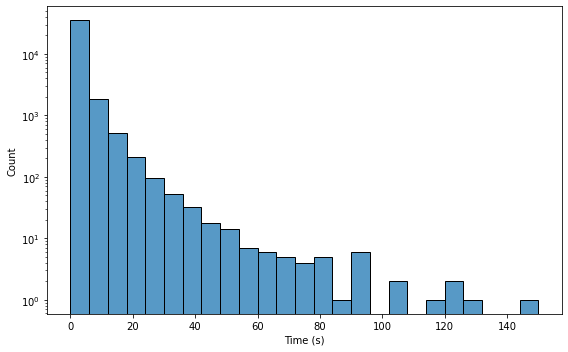

In [223]:
matplotlib.rcParams['figure.figsize'] = (8, 5)

# Difference in time between IEDs
diffs = np.diff(np.array([spikes[0] for spikes in all_seq_spikes]))# if len(spikes) > 1]))

# Only keep intervals < 3s
filtered_diffs = diffs#[diffs / freq < inter_ied_max]

inter_ied_max = math.ceil(np.percentile(filtered_diffs / freq, 99.9))

ax = sns.histplot(filtered_diffs / freq, bins=25, binrange=[0, 150])
ax.set_yscale('log')
ax.set(xlabel='Time (s)')
# plt.xlim([0, 70])
plt.tight_layout()
plt.savefig(image_dir + '/inter-IED-intervals.pdf')

### Plot IED durations

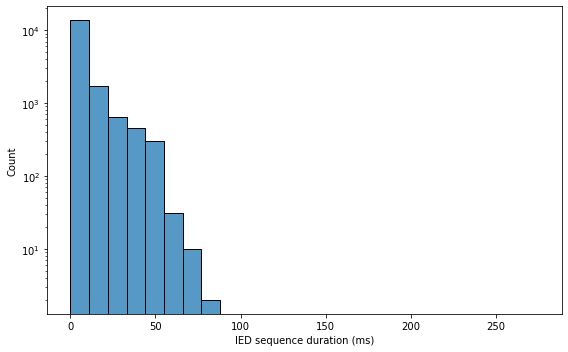

In [224]:
# Work out lengths for each sequence and convert to ms
length_list = [(1000/freq) * (spike[-1] - spike[0]) for spike in all_seq_spikes if len(spike) > 1]
length_list = [length_elem for length_elem in length_list]

ied_duration_max = math.ceil(np.percentile(length_list, 99.9))

ax = sns.histplot(length_list, bins=25, binrange=[0, 275])
ax.set_yscale('log')
ax.set(xlabel='IED sequence duration (ms)')

plt.tight_layout()
plt.savefig(image_dir + '/IED-durations.pdf')

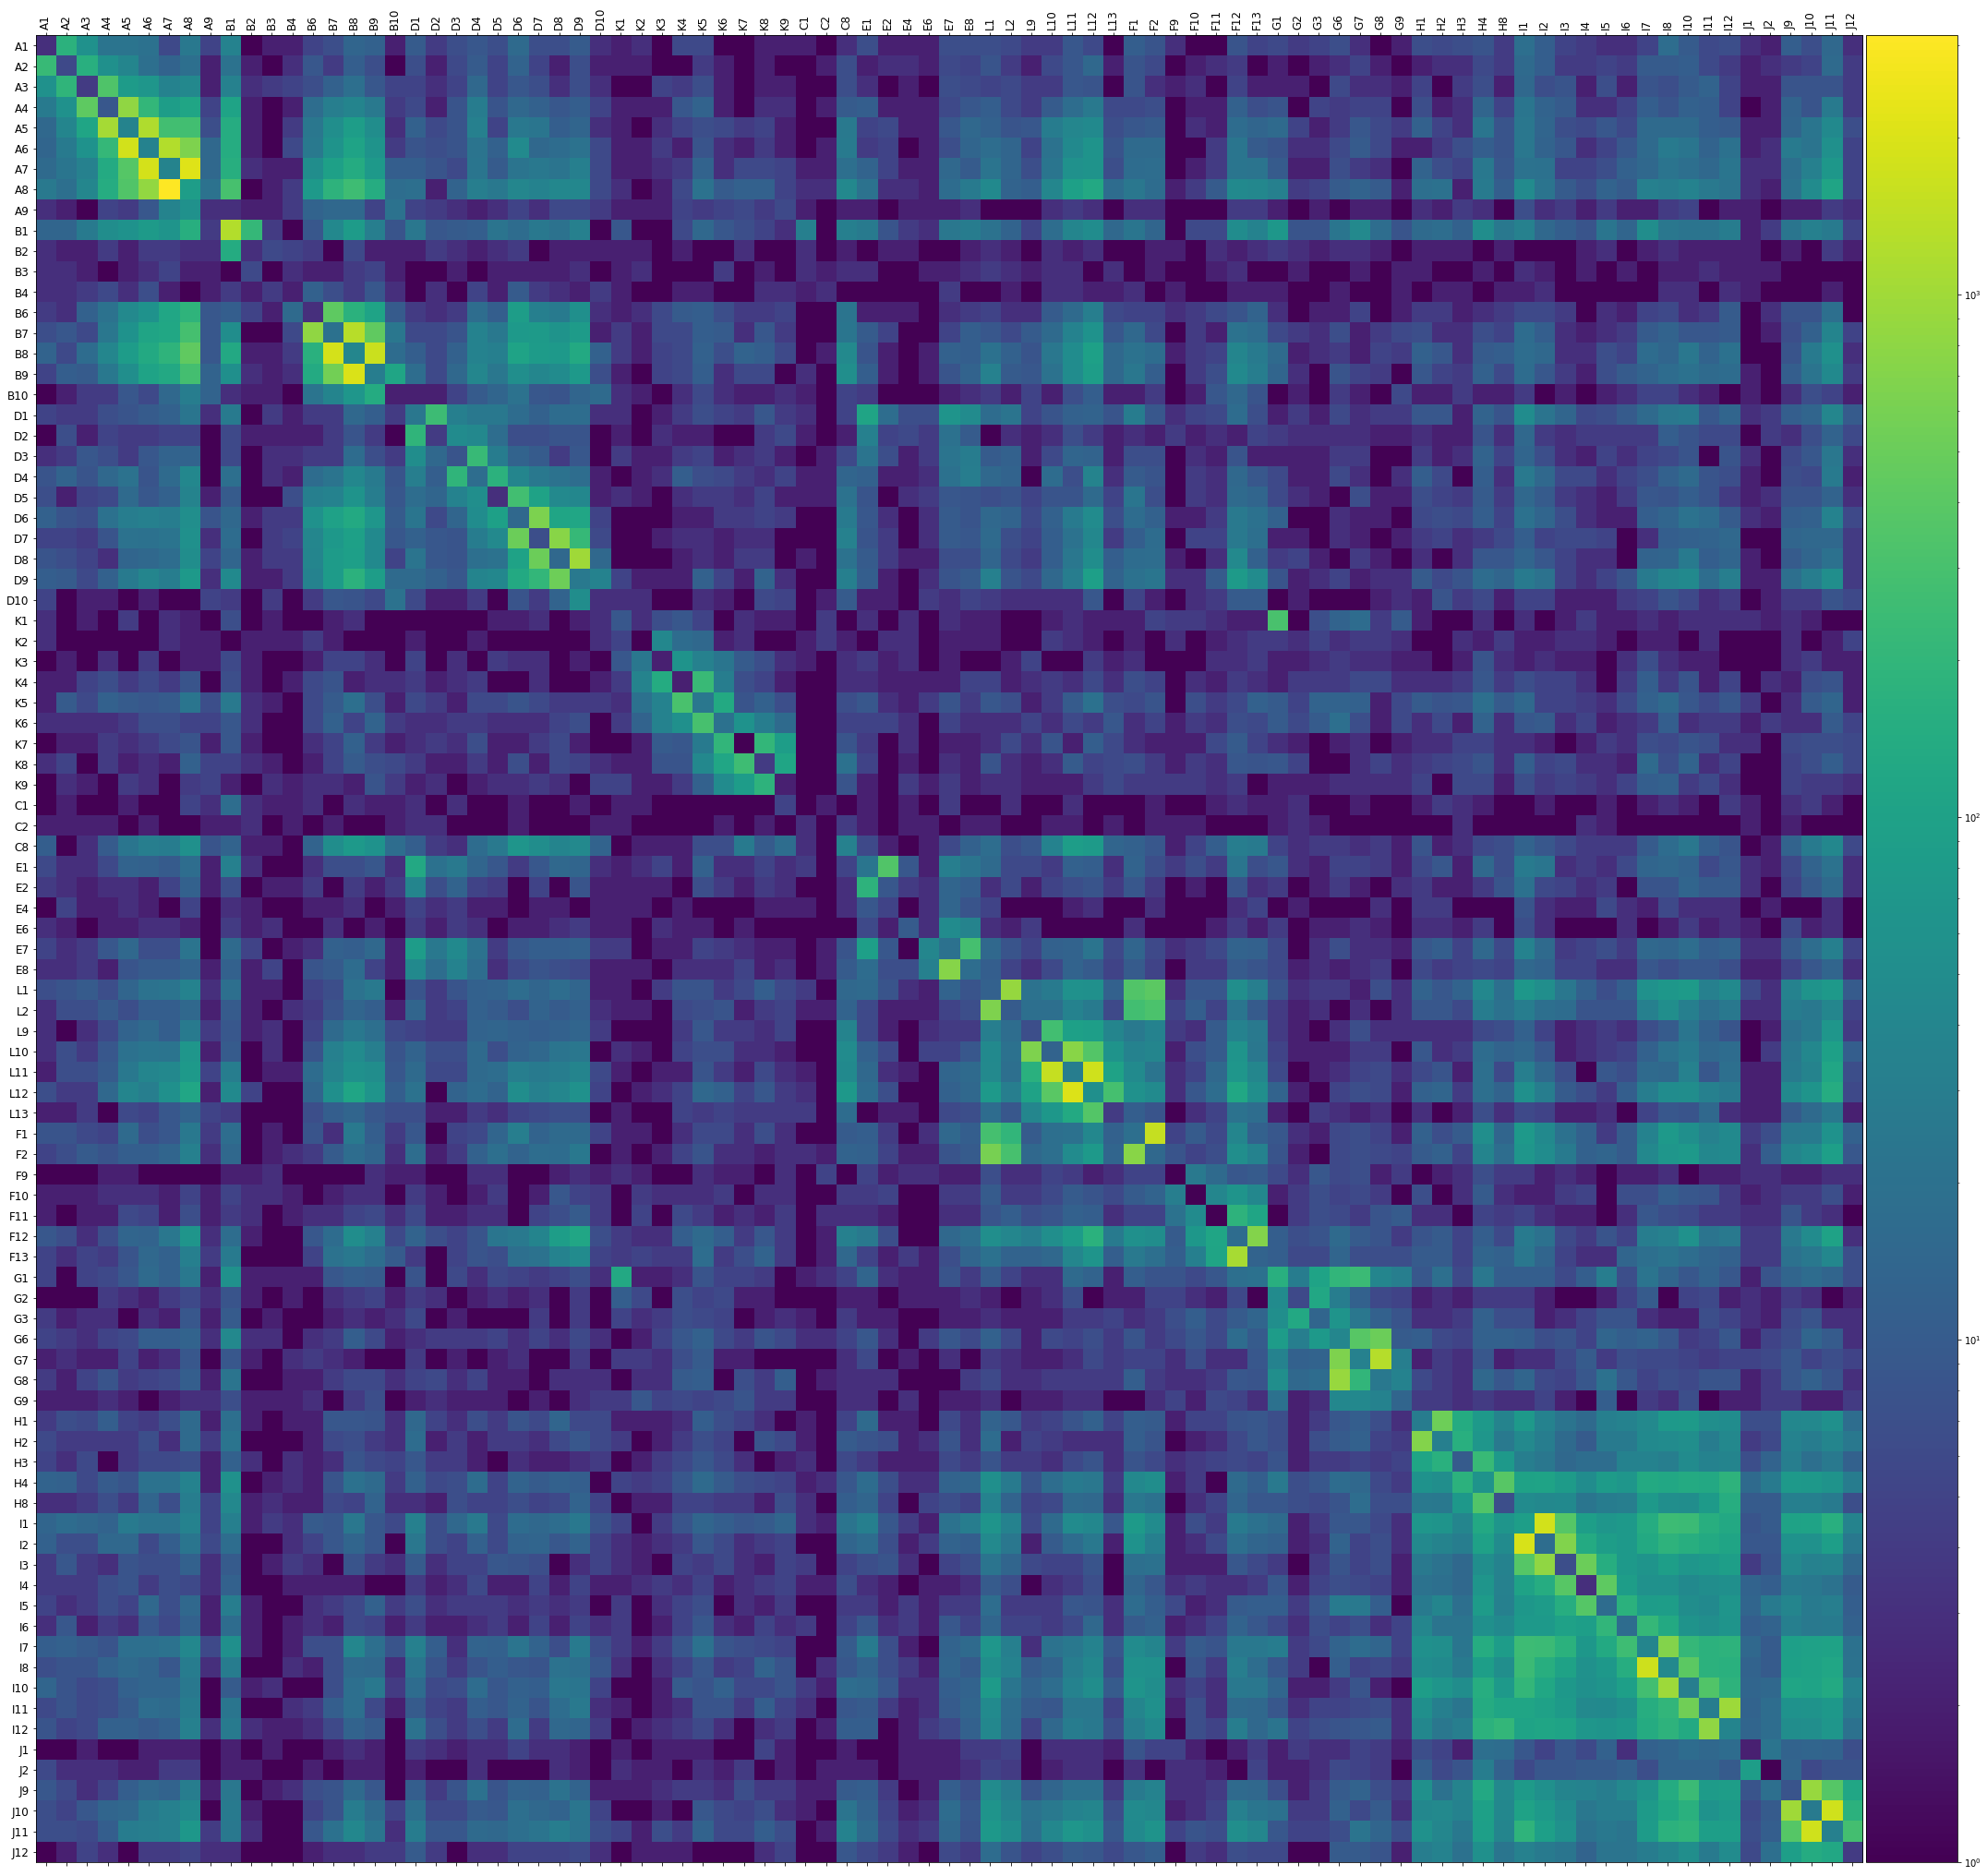

In [975]:
plt = transition_matrix = matshow_cluster(valid_channels_unmapped, all_seq_chans)
plt.tight_layout()
plt.savefig(image_dir + '/IED_transition_matrix.pdf')

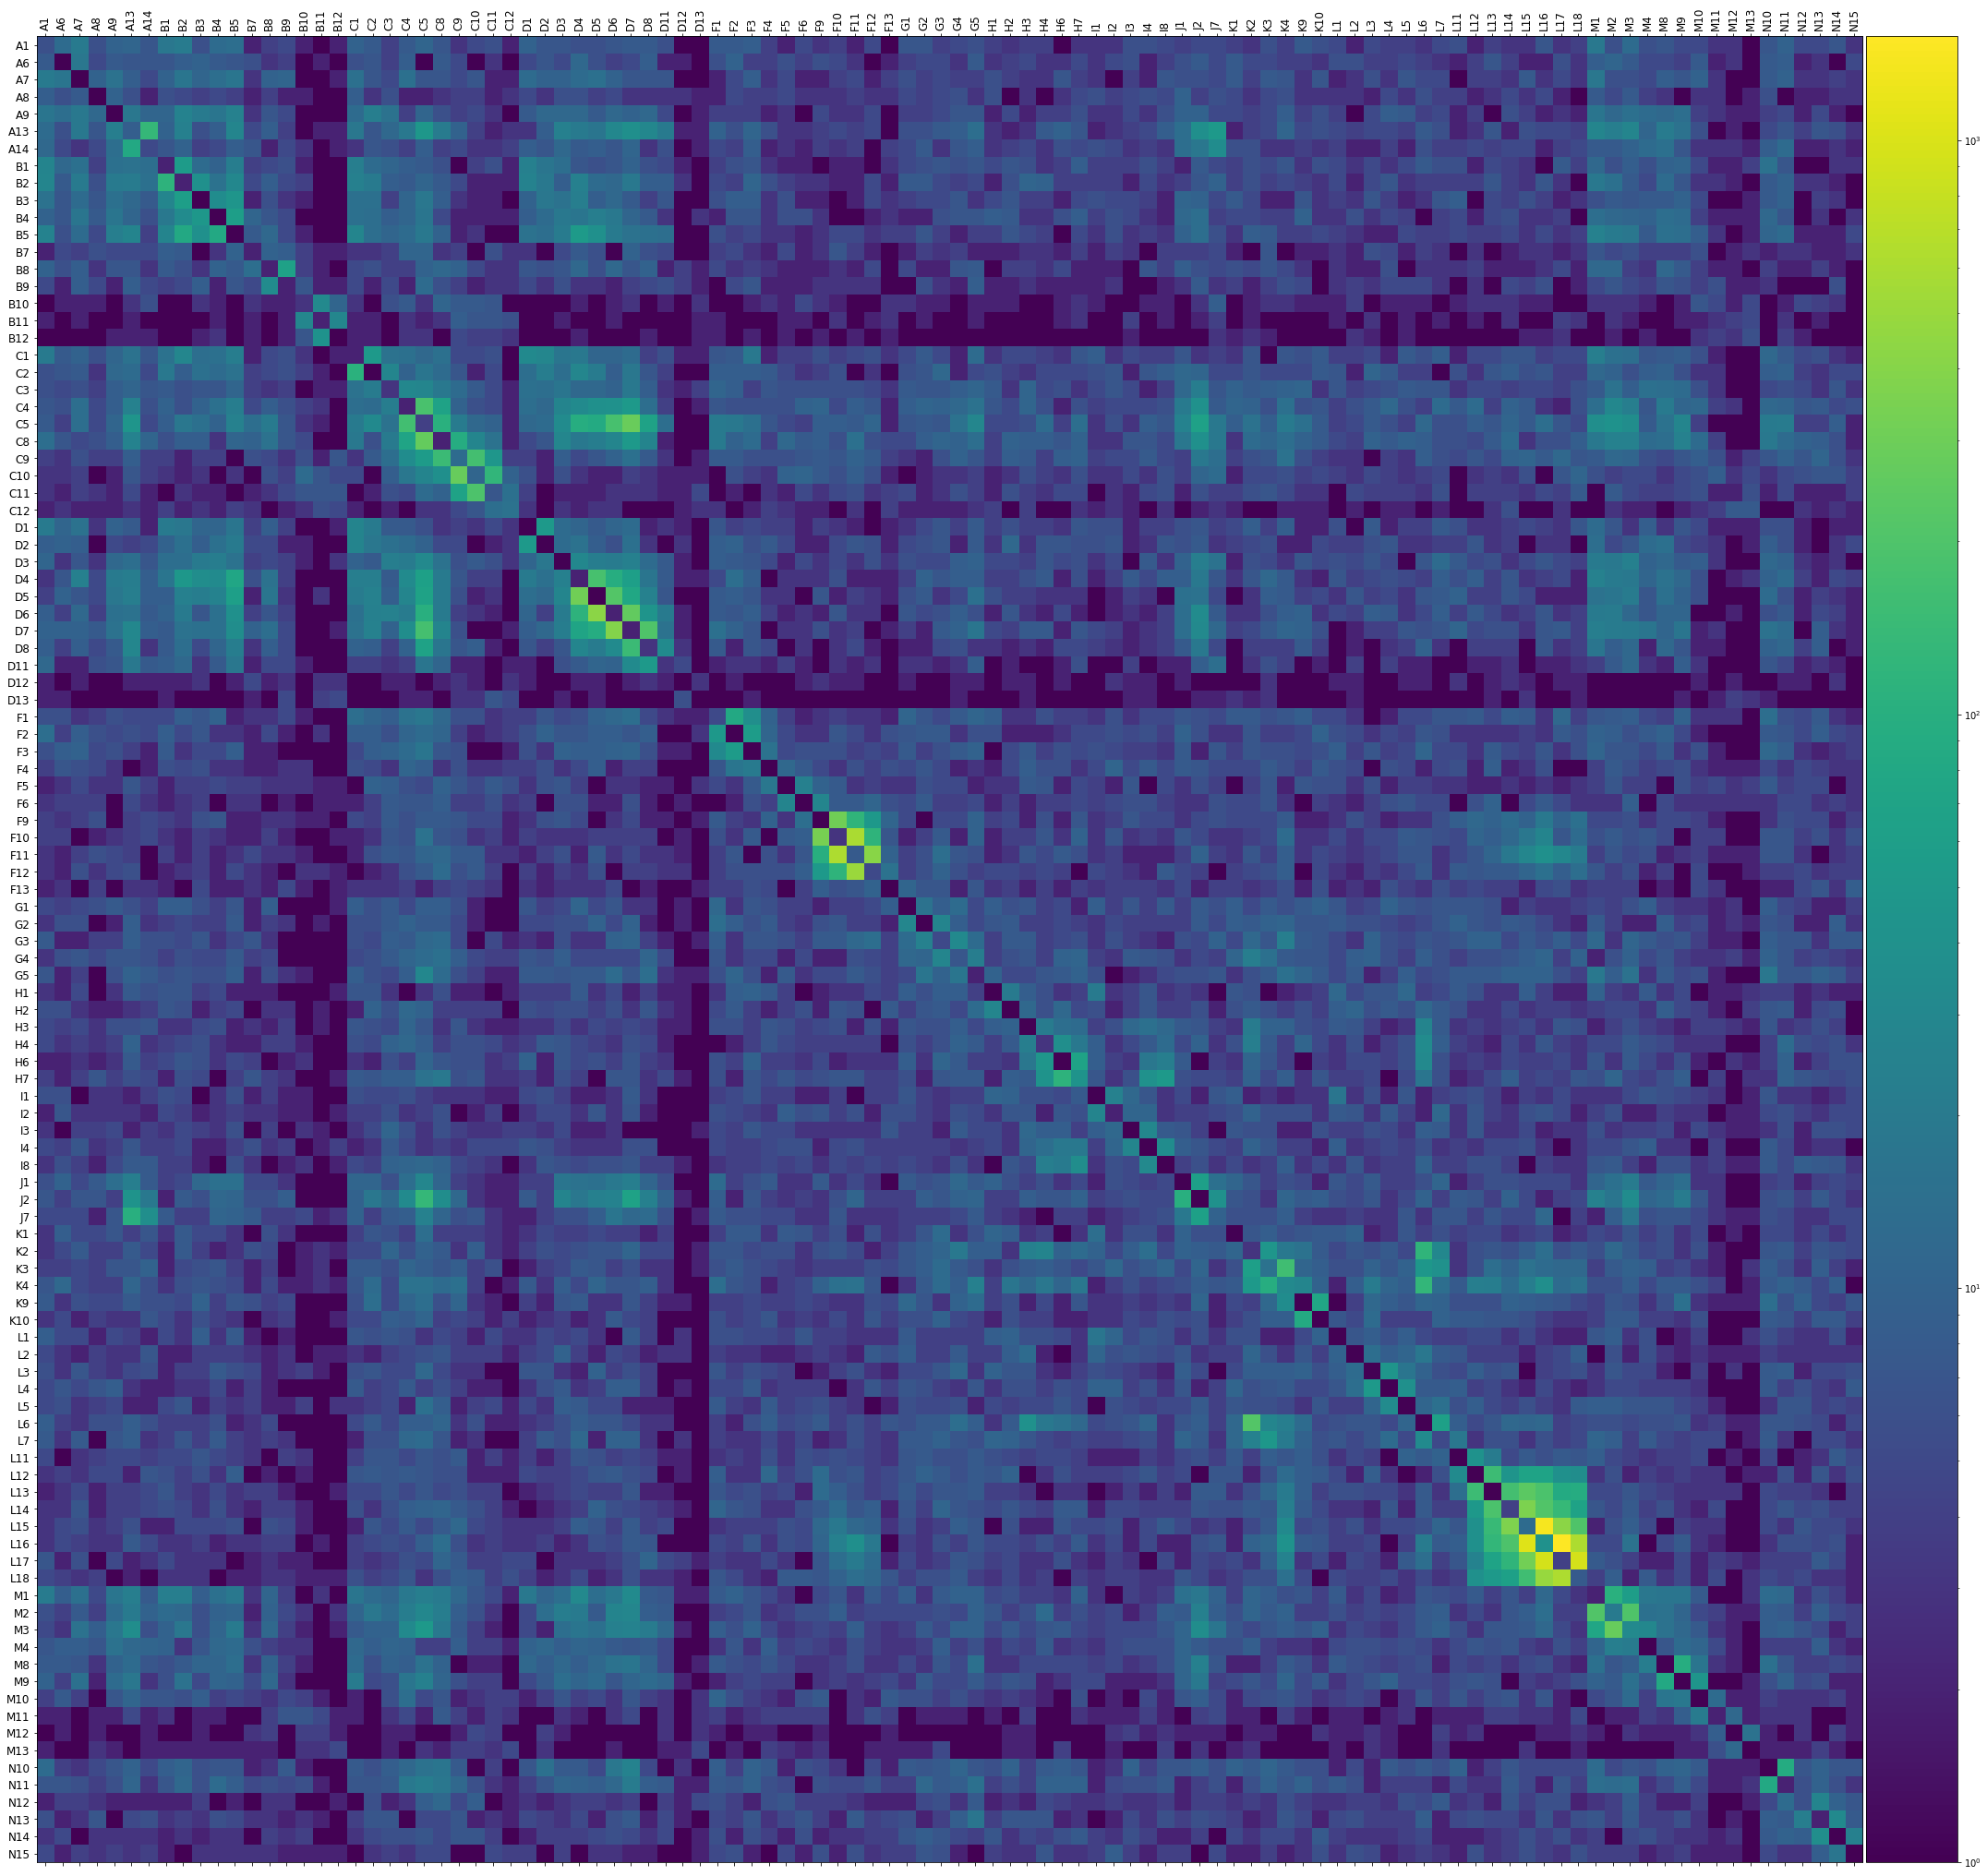

In [5]:
plt = matshow_cluster([valid_channel.split()[-1] for valid_channel in valid_channels], all_seq_chans)
plt.tight_layout()
# plt.savefig(image_dir + '/IED_transition_matrix.pdf')

Detect IED sequences from individual IED spikes. If an IED is within 50ms of the start of the current sequence, or 15ms from the last added spike in the sequence, it's added to the sequence.

### Create distance matrix for all pairs of IED sequences

In [96]:
len([all_seq_chan for all_seq_chan in all_seq_chans if len(all_seq_chan) > 1])

16813

In [97]:
all_seq_chans_chr = [''.join([chr(int(chan)) for chan in all_seq_chan]) \
                     for all_seq_chan in all_seq_chans if len(all_seq_chan) > 1]

In [23]:
# all_seq_chans_chr = list(np.array(all_seq_chans_chr)[::2])
all_seq_chans_chr = list(np.array(all_seq_chans_chr)[::2])

In [98]:
distance_matrix = np.array([[1 - Levenshtein.ratio(seq_1, seq_2) for j, seq_2 \
                             in enumerate(all_seq_chans_chr)] \
                            for i, seq_1 in enumerate(tqdm(all_seq_chans_chr))])

100%|████████████████████████████████████| 16813/16813 [01:54<00:00, 146.66it/s]


In [41]:
# distance_matrix = []
distance_matrix = np.zeros((len(all_seq_chans_chr), len(all_seq_chans_chr)), dtype=np.float16)
for i, seq_1 in tqdm(enumerate(all_seq_chans_chr)):
#     distance_matrix_row = []
    for j, seq_2 in enumerate(all_seq_chans_chr):
        distance_matrix[i, j] = 1 - Levenshtein.ratio(seq_1, seq_2)
#         distance = 1 - Levenshtein.ratio(seq_1, seq_2)
#         distance_matrix_row.append(distance)
#     distance_matrix.append(distance_matrix_row)
# distance_matrix = np.array(distance_matrix)

38490it [32:39, 19.64it/s]


In [50]:
# np.save('DaKa_distance_matrix.npy', distance_matrix)

In [183]:
distance_matrix = np.load('DaKa_distance_matrix.npy')

### Perform clustering

In [184]:
def cluster(eps=0.45):
    longer = [all_seq_chan for all_seq_chan in all_seq_chans if len(all_seq_chan) > 1]
#     longer = list(np.array(longer)[::2])
    start = time.time()

    clustering = DBSCAN(eps=eps, min_samples=500, metric='precomputed').fit(distance_matrix)
    
    print(time.time()-start)
    assigned_clusters = clustering.labels_
    
    cluster_counts = np.unique(assigned_clusters, return_counts=True)[1]

    print(cluster_counts)
    
#     transition_matrix = matshow_cluster([valid_channel.split()[-1] for valid_channel in valid_channels], longer, assigned_clusters, -1)
#     transition_matrix.tight_layout()
#     transition_matrix.savefig(image_dir + '/cluster_-1_0.2.pdf')
#     transition_matrix.show()

#     for cluster in range(-1, len(cluster_counts) - 1):
# #         transition_matrix = matshow_cluster(['' for valid_channel in valid_channels], longer, assigned_clusters, cluster)
#         transition_matrix = matshow_cluster([valid_channel.split()[-1] for valid_channel in valid_channels], longer, assigned_clusters, cluster)
#         transition_matrix.tight_layout()
# #         transition_matrix.savefig(image_dir + '/cluster' + str(cluster) + '.pdf')
#         transition_matrix.show()
        
    return assigned_clusters

import time
# for eps in [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
assigned_clusters = cluster(eps=0.3)


85.51456713676453
[23923  6833  1726   916  1896   765  1847   575     9]


/var/folders/s8/yc5ds6dn11ncxwggkx3c6wrc0000gn/T/ipykernel_60353/2665044057.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  longer = list(np.array(longer)[assigned_clusters == 0])


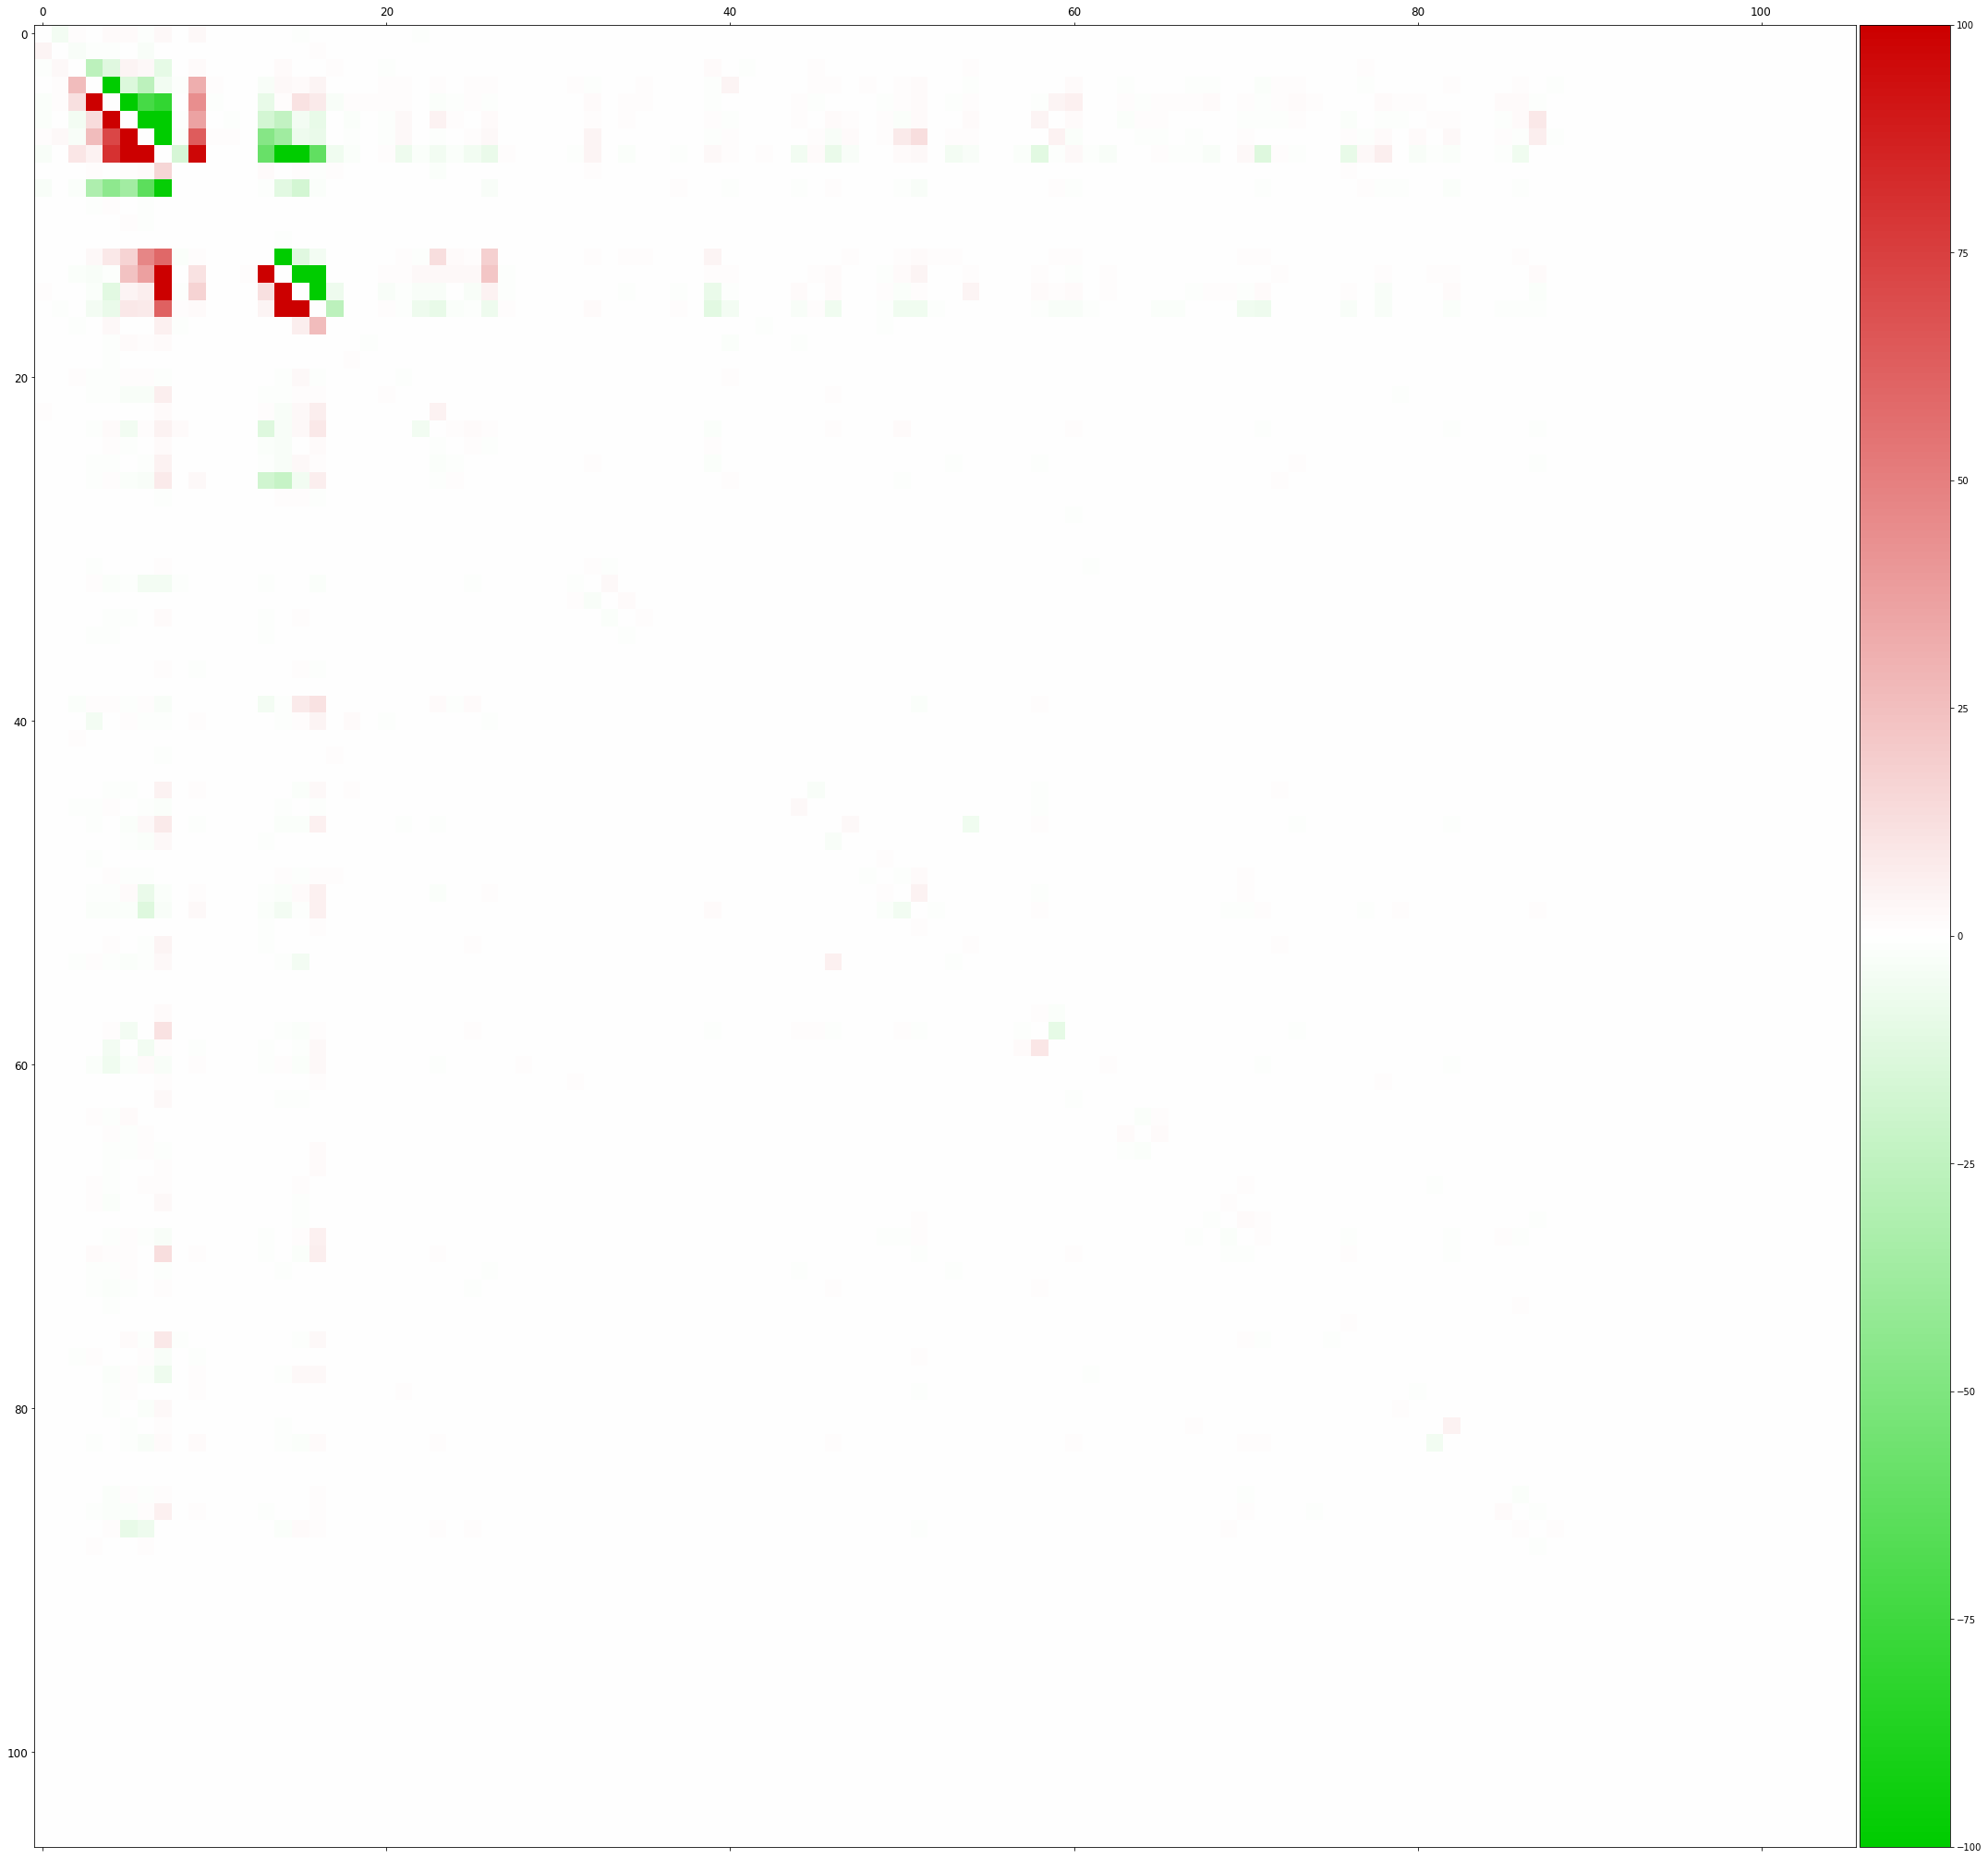

In [190]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

longer = [all_seq_chan for all_seq_chan in all_seq_chans if len(all_seq_chan) > 1]
longer = list(np.array(longer)[assigned_clusters == 0])

starts_list = [chan[:-1] for chan in longer]
ends_list = [chan[1:] for chan in longer]

pairs = []

for starts, ends in zip(starts_list, ends_list):
    for start, end in zip(starts, ends):
        pairs.append([int(start), int(end)])

unique, counts = np.unique(pairs, return_counts=True, axis=0)

sorted_counts = np.flip(np.argsort(counts))
counts = counts[sorted_counts]
unique = unique[sorted_counts]

matplotlib.rcParams['figure.figsize'] = (30, 30)

chans = len(valid_channels)

# Produce the matrix
counts_mat = np.zeros((chans, chans))
for c, u in zip(counts, unique):
    counts_mat[u[0]][u[1]] = c
    
# This dictionary defines the colormap
cdict = {'red':  ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

        'green': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0))   # no blue at 1
       }

GnRd = colors.LinearSegmentedColormap('GnRd', cdict)

counts_mat = counts_mat - counts_mat.T

# counts_mat[counts_mat == 0] = 0.00000001
# Display as a heatmap
fig = plt.figure()
ax = fig.add_subplot(111)

maxval = np.max(np.abs([counts_mat.min(),counts_mat.max()]))
im = ax.matshow(counts_mat, interpolation='nearest', cmap=GnRd, vmin=-100, vmax=100)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

ax.grid(False)
#     fig.colorbar(cax)

# Set ticks as appropriate
xaxis = np.arange(chans)

plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

plt.tight_layout()
plt.savefig(image_dir + '/cluster_0_directions.pdf')
# ax.set_xticks(xaxis)
# ax.set_yticks(xaxis)
# ax.set_xticklabels(valid_channels, rotation=90)
# ax.set_yticklabels(valid_channels)
#ax.set_xlabel('Channel', fontsize=30)

### Explore clusters

In [601]:
longer = [all_seq_chan for all_seq_chan in all_seq_chans if len(all_seq_chan) > 1]
# cluster_0 = list(np.array(longer)[::2][assigned_clusters == 0])
cluster_0 = list(np.array(longer)[assigned_clusters == 0])

/var/folders/s8/yc5ds6dn11ncxwggkx3c6wrc0000gn/T/ipykernel_39001/2372529174.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster_0 = list(np.array(longer)[assigned_clusters == 0])


In [603]:
from nltk import ngrams

cluster_0 = list(np.array(longer)[assigned_clusters == 0])

count = 0
for cluster in cluster_0:
    two_grams = ngrams(cluster, 2)
    for gram in two_grams:
        if 83 <= gram[0] <= 89 and 45 <= gram[1] <= 48:
            count += 1
            continue
        elif 83 <= gram[1] <= 89 and 45 <= gram[0] <= 48:
            count += 1
            continue
            
print(count/len(cluster_0))

0.04920825816796953


/var/folders/s8/yc5ds6dn11ncxwggkx3c6wrc0000gn/T/ipykernel_39001/2262969433.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster_0 = list(np.array(longer)[assigned_clusters == 0])


In [58]:
from nltk import ngrams

cluster_0 = list(np.array(longer)[::2][assigned_clusters == 0])

count = 0
for cluster in cluster_0:
    two_grams = ngrams(cluster, 2)
    for gram in two_grams:
        if 0 <= gram[0] <= 9 and 13 <= gram[1] <= 17:
            count += 1
            continue
        elif 0 <= gram[1] <= 9 and 13 <= gram[0] <= 17:
            count += 1
            continue
            
print(count/len(cluster_0))

0.1288056206088993


/var/folders/s8/yc5ds6dn11ncxwggkx3c6wrc0000gn/T/ipykernel_39001/1966134800.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cluster_0 = list(np.array(longer)[::2][assigned_clusters == 0])


Work out the most common routes within IED sequences and display the top 20.

In [99]:
# If a sequence is A -> B -> C, count A -> B as one connection and B -> C as another.
starts_list = [chan[:-1] for chan in all_seq_chans if len(chan) >= 2]
ends_list = [chan[1:] for chan in all_seq_chans if len(chan) >= 2]

pairs = []

for starts, ends in zip(starts_list, ends_list):
    for start, end in zip(starts, ends):
        pairs.append([int(start), int(end)])

unique, counts = np.unique(pairs, return_counts=True, axis=0)

sorted_counts = np.flip(np.argsort(counts))
counts = counts[sorted_counts]
unique = unique[sorted_counts]

for u, c in zip(unique, counts):
    print(c, valid_channels[u[0]], '->', valid_channels[u[1]])

961 EEG L16 -> EEG L17
954 EEG L15 -> EEG L16
692 EEG L16 -> EEG L15
570 EEG L17 -> EEG L16
437 EEG L17 -> EEG L18
422 EEG F11 -> EEG F10
373 EEG F12 -> EEG F11
359 EEG F10 -> EEG F11
330 EEG L18 -> EEG L17
327 EEG D6 -> EEG D5
322 EEG L16 -> EEG L18
311 EEG L18 -> EEG L16
285 EEG D7 -> EEG D6
264 EEG L15 -> EEG L17
246 EEG L14 -> EEG L15
231 EEG C5 -> EEG D7
224 EEG F9 -> EEG F10
219 EEG F11 -> EEG F12
214 EEG D5 -> EEG D4
211 EEG M3 -> EEG M2
206 EEG C8 -> EEG C5
196 EEG L15 -> EEG L14
190 EEG C10 -> EEG C9
183 EEG D6 -> EEG D7
163 EEG F10 -> EEG F9
161 EEG D5 -> EEG D6
154 EEG L17 -> EEG L15
149 EEG L13 -> EEG L15
148 EEG D4 -> EEG D5
146 EEG L14 -> EEG L16
143 EEG C5 -> EEG D6
140 EEG C11 -> EEG C10
138 EEG L6 -> EEG K2
138 EEG C9 -> EEG C10
136 EEG M2 -> EEG M3
132 EEG C5 -> EEG C4
132 EEG C4 -> EEG C5
129 EEG M2 -> EEG M1
128 EEG L14 -> EEG L13
118 EEG L16 -> EEG L14
116 EEG D7 -> EEG C5
114 EEG D7 -> EEG D8
111 EEG C9 -> EEG C8
111 EEG L13 -> EEG L14
111 EEG L13 -> EEG L16
107 E

12 EEG D7 -> EEG B3
12 EEG K9 -> EEG C2
12 EEG J1 -> EEG D4
12 EEG G4 -> EEG K2
12 EEG D5 -> EEG C8
12 EEG D5 -> EEG D2
12 EEG D5 -> EEG A13
12 EEG D11 -> EEG B5
12 EEG J1 -> EEG D7
12 EEG D5 -> EEG A9
12 EEG D11 -> EEG C5
12 EEG K9 -> EEG K3
12 EEG J7 -> EEG J1
12 EEG L2 -> EEG L6
12 EEG G4 -> EEG G5
12 EEG M1 -> EEG B1
12 EEG M4 -> EEG M1
12 EEG J2 -> EEG M8
12 EEG H4 -> EEG I3
12 EEG D4 -> EEG C3
12 EEG K2 -> EEG G4
12 EEG L6 -> EEG H4
12 EEG F11 -> EEG C5
12 EEG K4 -> EEG K10
12 EEG M2 -> EEG M8
12 EEG D4 -> EEG A13
12 EEG H2 -> EEG L6
12 EEG N15 -> EEG N14
12 EEG C10 -> EEG C4
12 EEG A9 -> EEG D4
12 EEG C12 -> EEG C12
12 EEG C4 -> EEG M9
12 EEG C1 -> EEG C5
12 EEG C10 -> EEG F11
12 EEG B2 -> EEG D1
12 EEG C1 -> EEG B3
12 EEG N12 -> EEG N11
12 EEG A13 -> EEG C1
12 EEG C5 -> EEG B8
12 EEG N11 -> EEG D3
12 EEG N11 -> EEG C5
12 EEG C9 -> EEG K4
12 EEG B1 -> EEG A6
12 EEG A13 -> EEG M8
12 EEG B5 -> EEG M3
12 EEG B5 -> EEG M2
12 EEG A14 -> EEG A9
12 EEG B5 -> EEG A1
12 EEG C8 -> EEG F1


8 EEG M12 -> EEG M13
8 EEG B8 -> EEG C5
8 EEG A7 -> EEG B9
8 EEG I4 -> EEG L6
8 EEG C5 -> EEG F9
8 EEG J1 -> EEG D2
8 EEG N11 -> EEG B2
8 EEG I4 -> EEG H6
8 EEG D8 -> EEG A1
8 EEG C5 -> EEG D11
8 EEG A7 -> EEG C1
8 EEG K3 -> EEG N10
8 EEG K3 -> EEG L11
8 EEG B8 -> EEG B7
8 EEG B8 -> EEG B2
8 EEG D1 -> EEG M8
8 EEG I8 -> EEG H6
8 EEG B8 -> EEG A1
8 EEG C5 -> EEG H6
8 EEG K4 -> EEG L2
8 EEG D7 -> EEG D2
8 EEG B5 -> EEG N10
8 EEG B1 -> EEG M1
8 EEG D1 -> EEG D5
8 EEG M10 -> EEG J2
8 EEG A14 -> EEG A1
8 EEG M3 -> EEG C1
8 EEG J1 -> EEG C2
8 EEG A14 -> EEG M3
8 EEG C11 -> EEG C8
8 EEG L14 -> EEG G5
8 EEG J1 -> EEG M8
8 EEG B3 -> EEG A7
8 EEG D3 -> EEG M8
8 EEG D3 -> EEG M4
8 EEG J8 -> EEG A15
8 EEG B2 -> EEG M8
8 EEG D4 -> EEG G5
8 EEG C8 -> EEG N11
8 EEG B3 -> EEG A13
8 EEG A14 -> EEG M4
8 EEG M1 -> EEG N11
8 EEG M2 -> EEG D8
8 EEG B3 -> EEG C3
8 EEG K2 -> EEG G2
8 EEG J7 -> EEG H7
8 EEG L16 -> EEG C9
8 EEG D3 -> EEG M9
8 EEG M2 -> EEG C9
8 EEG A6 -> EEG C2
8 EEG C9 -> EEG F11
8 EEG D3 -> 

6 EEG M2 -> EEG H3
6 EEG L6 -> EEG L13
6 EEG D3 -> EEG I8
6 EEG J7 -> EEG C1
6 EEG F12 -> EEG G2
6 EEG J2 -> EEG B1
6 EEG C9 -> EEG G4
6 EEG D3 -> EEG I4
6 EEG F12 -> EEG K4
6 EEG J1 -> EEG L12
6 EEG D3 -> EEG D11
6 EEG B7 -> EEG B9
6 EEG J1 -> EEG I3
6 EEG J1 -> EEG K1
6 EEG F1 -> EEG M2
6 EEG C8 -> EEG N12
6 EEG C9 -> EEG I8
6 EEG L7 -> EEG A1
6 EEG F11 -> EEG M2
6 EEG F1 -> EEG M3
6 EEG C9 -> EEG I2
6 EEG C8 -> EEG N13
6 EEG J1 -> EEG L7
6 EEG M2 -> EEG F3
6 EEG A9 -> EEG D3
6 EEG L6 -> EEG L2
6 EEG J2 -> EEG C9
6 EEG J2 -> EEG B4
6 EEG L6 -> EEG D5
6 EEG B7 -> EEG C5
6 EEG F2 -> EEG B2
6 EEG L6 -> EEG G3
6 EEG L6 -> EEG G2
6 EEG F2 -> EEG C4
6 EEG L6 -> EEG G1
6 EEG J2 -> EEG N10
6 EEG J2 -> EEG K2
6 EEG J2 -> EEG B7
6 EEG L6 -> EEG F10
6 EEG C9 -> EEG D8
6 EEG F12 -> EEG B5
6 EEG J2 -> EEG L13
6 EEG J2 -> EEG L15
6 EEG M2 -> EEG G5
6 EEG M2 -> EEG H1
6 EEG F12 -> EEG C5
6 EEG A9 -> EEG G1
6 EEG A9 -> EEG I1
6 EEG F12 -> EEG C8
6 EEG J2 -> EEG C2
6 EEG F2 -> EEG D7
6 EEG M2 -> EEG 

5 EEG K2 -> EEG L16
5 EEG K2 -> EEG M1
5 EEG B3 -> EEG C4
5 EEG B3 -> EEG C8
5 EEG K2 -> EEG M3
5 EEG H3 -> EEG A6
5 EEG C5 -> EEG F6
5 EEG C2 -> EEG N10
5 EEG G2 -> EEG N14
5 EEG M8 -> EEG F10
5 EEG G4 -> EEG M8
5 EEG C8 -> EEG A1
5 EEG C2 -> EEG L6
5 EEG M1 -> EEG L14
5 EEG G4 -> EEG M3
5 EEG K2 -> EEG H7
5 EEG C2 -> EEG L4
5 EEG K2 -> EEG G5
5 EEG M1 -> EEG N10
5 EEG C2 -> EEG L3
5 EEG M8 -> EEG N11
5 EEG M4 -> EEG L6
5 EEG K2 -> EEG F6
5 EEG F9 -> EEG M1
5 EEG B3 -> EEG F4
5 EEG F9 -> EEG M3
5 EEG H2 -> EEG N10
5 EEG G5 -> EEG A1
5 EEG K3 -> EEG I3
5 EEG H2 -> EEG J7
5 EEG C11 -> EEG D1
5 EEG M1 -> EEG K1
5 EEG K3 -> EEG F3
5 EEG G1 -> EEG L1
5 EEG B9 -> EEG A15
5 EEG N12 -> EEG C10
5 EEG K3 -> EEG F12
5 EEG I1 -> EEG F10
5 EEG B2 -> EEG N10
5 EEG K4 -> EEG K1
5 EEG K3 -> EEG G4
5 EEG C11 -> EEG F6
5 EEG K3 -> EEG H2
5 EEG C11 -> EEG F11
5 EEG B9 -> EEG A9
5 EEG B9 -> EEG A7
5 EEG M4 -> EEG L3
5 EEG B3 -> EEG A6
5 EEG L16 -> EEG M2
5 EEG C11 -> EEG C11
5 EEG K3 -> EEG D2
5 EEG H2 -

5 EEG L7 -> EEG G5
5 EEG F1 -> EEG J2
5 EEG F1 -> EEG J1
5 EEG L6 -> EEG L17
5 EEG L6 -> EEG L16
5 EEG D3 -> EEG L5
5 EEG L6 -> EEG L12
5 EEG F1 -> EEG N10
5 EEG M9 -> EEG K9
5 EEG L11 -> EEG D7
5 EEG F2 -> EEG M4
5 EEG L11 -> EEG L2
5 EEG L5 -> EEG G5
5 EEG D4 -> EEG H1
5 EEG D3 -> EEG A14
5 EEG D3 -> EEG A9
5 EEG D4 -> EEG I8
5 EEG L12 -> EEG A6
5 EEG N15 -> EEG A1
5 EEG D4 -> EEG K1
5 EEG A13 -> EEG C9
5 EEG L12 -> EEG C1
5 EEG L5 -> EEG C8
5 EEG L12 -> EEG C4
5 EEG L12 -> EEG C5
5 EEG L5 -> EEG C3
5 EEG L5 -> EEG C2
5 EEG D4 -> EEG L7
5 EEG D4 -> EEG L11
5 EEG L12 -> EEG D2
5 EEG L5 -> EEG B5
5 EEG D4 -> EEG L12
5 EEG L12 -> EEG D4
5 EEG L12 -> EEG F4
5 EEG L12 -> EEG F6
5 EEG D3 -> EEG B8
5 EEG L11 -> EEG K2
5 EEG L11 -> EEG F2
5 EEG D3 -> EEG C9
5 EEG L11 -> EEG F3
5 EEG L6 -> EEG A8
5 EEG L6 -> EEG A1
5 EEG L11 -> EEG F10
5 EEG D3 -> EEG F1
5 EEG L5 -> EEG N10
5 EEG F1 -> EEG A14
5 EEG L11 -> EEG G4
5 EEG F2 -> EEG F12
5 EEG D3 -> EEG C11
5 EEG F1 -> EEG A9
5 EEG F2 -> EEG G2
5 

4 EEG L14 -> EEG L11
4 EEG C2 -> EEG I3
4 EEG L14 -> EEG L7
4 EEG G4 -> EEG L11
4 EEG H4 -> EEG C9
4 EEG L14 -> EEG L4
4 EEG C2 -> EEG C10
4 EEG H4 -> EEG F6
4 EEG G4 -> EEG F10
4 EEG D8 -> EEG F11
4 EEG H4 -> EEG D3
4 EEG A6 -> EEG D4
4 EEG H4 -> EEG D8
4 EEG C2 -> EEG I8
4 EEG N11 -> EEG G4
4 EEG H4 -> EEG F5
4 EEG G3 -> EEG L5
4 EEG L13 -> EEG L3
4 EEG H2 -> EEG C1
4 EEG G2 -> EEG N10
4 EEG N11 -> EEG B1
4 EEG C3 -> EEG C12
4 EEG D11 -> EEG M9
4 EEG L12 -> EEG L5
4 EEG I1 -> EEG D2
4 EEG N11 -> EEG A14
4 EEG C5 -> EEG F4
4 EEG B11 -> EEG J7
4 EEG A7 -> EEG I8
4 EEG I1 -> EEG F3
4 EEG C5 -> EEG F5
4 EEG L12 -> EEG L1
4 EEG I1 -> EEG F12
4 EEG D5 -> EEG D11
4 EEG I1 -> EEG G1
4 EEG C4 -> EEG H2
4 EEG I1 -> EEG G2
4 EEG A7 -> EEG J2
4 EEG L16 -> EEG N15
4 EEG N12 -> EEG C2
4 EEG H2 -> EEG F9
4 EEG H2 -> EEG F13
4 EEG I1 -> EEG B2
4 EEG N12 -> EEG L17
4 EEG G3 -> EEG D4
4 EEG G3 -> EEG D3
4 EEG M4 -> EEG F4
4 EEG L15 -> EEG K3
4 EEG N12 -> EEG M2
4 EEG G3 -> EEG D1
4 EEG L12 -> EEG M4
4

4 EEG A9 -> EEG L4
4 EEG L6 -> EEG A6
4 EEG M2 -> EEG L2
4 EEG L5 -> EEG M10
4 EEG M2 -> EEG L1
4 EEG J7 -> EEG F10
4 EEG F2 -> EEG F5
4 EEG M2 -> EEG K10
4 EEG F11 -> EEG L12
4 EEG M2 -> EEG F4
4 EEG L5 -> EEG N12
4 EEG L17 -> EEG N12
4 EEG D3 -> EEG G5
4 EEG D3 -> EEG H1
4 EEG J7 -> EEG F1
4 EEG L6 -> EEG L3
4 EEG L6 -> EEG A9
4 EEG N13 -> EEG D1
4 EEG J7 -> EEG I8
4 EEG L6 -> EEG L18
4 EEG B5 -> EEG L17
4 EEG F11 -> EEG J7
4 EEG L6 -> EEG A14
4 EEG N13 -> EEG F9
4 EEG B5 -> EEG D11
4 EEG C9 -> EEG K2
4 EEG F11 -> EEG K4
4 EEG J7 -> EEG J7
4 EEG F11 -> EEG K9
4 EEG L17 -> EEG M4
4 EEG A9 -> EEG D8
4 EEG L5 -> EEG M2
4 EEG L6 -> EEG J1
4 EEG J7 -> EEG I4
4 EEG F12 -> EEG G3
4 EEG D3 -> EEG H6
4 EEG B5 -> EEG L6
4 EEG B5 -> EEG B7
4 EEG M2 -> EEG F2
4 EEG L6 -> EEG A13
4 EEG L5 -> EEG L17
4 EEG L5 -> EEG M1
4 EEG C9 -> EEG J8
4 EEG F11 -> EEG F2
4 EEG M8 -> EEG K4
4 EEG M12 -> EEG F13
4 EEG L6 -> EEG D6
4 EEG F2 -> EEG B3
4 EEG L7 -> EEG B5
4 EEG C9 -> EEG F3
4 EEG B5 -> EEG H7
4 EEG J

3 EEG D5 -> EEG L1
3 EEG F9 -> EEG J7
3 EEG G3 -> EEG J1
3 EEG D5 -> EEG L2
3 EEG N10 -> EEG K2
3 EEG N11 -> EEG F5
3 EEG M8 -> EEG G2
3 EEG F9 -> EEG G4
3 EEG F9 -> EEG D1
3 EEG G1 -> EEG B3
3 EEG F3 -> EEG I1
3 EEG F9 -> EEG D7
3 EEG C11 -> EEG F13
3 EEG F9 -> EEG D4
3 EEG F9 -> EEG D2
3 EEG G3 -> EEG M10
3 EEG C5 -> EEG A15
3 EEG G1 -> EEG C5
3 EEG F11 -> EEG M4
3 EEG F3 -> EEG I3
3 EEG G1 -> EEG A14
3 EEG M11 -> EEG L12
3 EEG F3 -> EEG J1
3 EEG F3 -> EEG J7
3 EEG D2 -> EEG H7
3 EEG G3 -> EEG M3
3 EEG G3 -> EEG M2
3 EEG D2 -> EEG I3
3 EEG C11 -> EEG F9
3 EEG M9 -> EEG K3
3 EEG F1 -> EEG B1
3 EEG D3 -> EEG F6
3 EEG G3 -> EEG L11
3 EEG G1 -> EEG C2
3 EEG C11 -> EEG D6
3 EEG F3 -> EEG H4
3 EEG D11 -> EEG B8
3 EEG F1 -> EEG B2
3 EEG F3 -> EEG H6
3 EEG C11 -> EEG D13
3 EEG G3 -> EEG L13
3 EEG F11 -> EEG M1
3 EEG G3 -> EEG L15
3 EEG C8 -> EEG B10
3 EEG F13 -> EEG D3
3 EEG M10 -> EEG J7
3 EEG C4 -> EEG B10
3 EEG K10 -> EEG I4
3 EEG N14 -> EEG F5
3 EEG K10 -> EEG H3
3 EEG K10 -> EEG G5
3 EE

3 EEG L18 -> EEG A9
3 EEG L6 -> EEG C11
3 EEG A8 -> EEG B7
3 EEG A8 -> EEG G4
3 EEG L17 -> EEG I2
3 EEG L11 -> EEG C3
3 EEG L11 -> EEG B5
3 EEG L11 -> EEG A1
3 EEG A8 -> EEG I8
3 EEG A8 -> EEG J1
3 EEG L7 -> EEG M13
3 EEG L7 -> EEG M10
3 EEG L7 -> EEG M8
3 EEG L7 -> EEG M1
3 EEG A8 -> EEG K4
3 EEG L7 -> EEG L16
3 EEG L17 -> EEG J7
3 EEG A8 -> EEG L4
3 EEG L17 -> EEG K2
3 EEG A8 -> EEG L6
3 EEG A8 -> EEG L7
3 EEG A8 -> EEG H1
3 EEG L11 -> EEG D1
3 EEG L6 -> EEG D8
3 EEG A8 -> EEG G1
3 EEG A8 -> EEG B8
3 EEG L17 -> EEG H3
3 EEG L17 -> EEG H4
3 EEG L17 -> EEG H7
3 EEG L11 -> EEG L1
3 EEG L11 -> EEG K4
3 EEG L11 -> EEG I8
3 EEG A8 -> EEG D1
3 EEG A8 -> EEG D2
3 EEG L11 -> EEG H2
3 EEG L11 -> EEG G1
3 EEG L11 -> EEG F12
3 EEG N15 -> EEG F10
3 EEG L11 -> EEG F6
3 EEG A8 -> EEG F4
3 EEG A8 -> EEG F5
3 EEG A8 -> EEG F11
3 EEG L7 -> EEG J7
3 EEG L7 -> EEG I8
3 EEG L7 -> EEG I4
3 EEG A8 -> EEG M2
3 EEG L17 -> EEG M2
3 EEG L17 -> EEG M8
3 EEG L6 -> EEG L4
3 EEG L17 -> EEG M10
3 EEG L6 -> EEG J8
3

2 EEG C2 -> EEG F6
2 EEG A6 -> EEG C10
2 EEG D5 -> EEG B9
2 EEG M11 -> EEG D11
2 EEG M11 -> EEG D3
2 EEG A7 -> EEG L2
2 EEG C2 -> EEG F9
2 EEG M11 -> EEG D1
2 EEG M11 -> EEG C11
2 EEG A7 -> EEG I4
2 EEG C2 -> EEG F13
2 EEG A7 -> EEG K9
2 EEG N15 -> EEG G2
2 EEG A6 -> EEG D3
2 EEG N12 -> EEG D7
2 EEG A7 -> EEG J1
2 EEG C4 -> EEG H4
2 EEG A6 -> EEG D6
2 EEG A6 -> EEG D7
2 EEG D5 -> EEG H6
2 EEG D5 -> EEG I1
2 EEG M10 -> EEG M13
2 EEG M11 -> EEG B9
2 EEG C2 -> EEG L2
2 EEG D5 -> EEG L16
2 EEG M11 -> EEG B11
2 EEG N15 -> EEG J8
2 EEG N15 -> EEG L4
2 EEG N15 -> EEG K2
2 EEG D6 -> EEG B7
2 EEG A6 -> EEG M9
2 EEG N12 -> EEG C12
2 EEG A6 -> EEG M8
2 EEG D5 -> EEG I3
2 EEG C2 -> EEG N15
2 EEG C2 -> EEG N14
2 EEG N12 -> EEG D3
2 EEG A6 -> EEG L15
2 EEG M11 -> EEG B3
2 EEG D5 -> EEG N13
2 EEG A6 -> EEG L3
2 EEG D6 -> EEG A8
2 EEG A6 -> EEG L5
2 EEG A6 -> EEG I4
2 EEG N15 -> EEG I2
2 EEG A6 -> EEG I2
2 EEG N15 -> EEG H7
2 EEG D5 -> EEG I8
2 EEG M11 -> EEG C3
2 EEG C2 -> EEG I4
2 EEG D5 -> EEG K3
2

2 EEG N10 -> EEG L7
2 EEG D1 -> EEG L1
2 EEG D1 -> EEG L2
2 EEG D1 -> EEG L5
2 EEG B9 -> EEG D1
2 EEG D1 -> EEG L13
2 EEG A15 -> EEG F6
2 EEG D1 -> EEG L14
2 EEG C5 -> EEG L17
2 EEG N10 -> EEG L12
2 EEG B9 -> EEG N14
2 EEG A1 -> EEG A1
2 EEG M10 -> EEG I8
2 EEG I1 -> EEG M11
2 EEG I2 -> EEG C10
2 EEG I2 -> EEG C5
2 EEG I2 -> EEG C4
2 EEG I2 -> EEG B4
2 EEG I2 -> EEG B2
2 EEG I2 -> EEG A13
2 EEG I2 -> EEG A8
2 EEG I2 -> EEG A6
2 EEG I2 -> EEG A1
2 EEG I1 -> EEG N14
2 EEG I1 -> EEG N13
2 EEG I1 -> EEG M10
2 EEG I2 -> EEG F12
2 EEG I1 -> EEG M8
2 EEG I1 -> EEG M4
2 EEG I1 -> EEG M2
2 EEG I1 -> EEG L14
2 EEG I1 -> EEG L7
2 EEG I1 -> EEG L6
2 EEG I1 -> EEG L3
2 EEG I1 -> EEG L2
2 EEG I1 -> EEG K9
2 EEG I1 -> EEG J8
2 EEG I1 -> EEG H4
2 EEG I2 -> EEG D4
2 EEG I2 -> EEG H4
2 EEG I3 -> EEG F9
2 EEG I3 -> EEG B3
2 EEG M3 -> EEG H2
2 EEG I3 -> EEG F3
2 EEG I3 -> EEG F1
2 EEG I3 -> EEG D4
2 EEG I3 -> EEG D3
2 EEG I3 -> EEG D2
2 EEG I3 -> EEG C11
2 EEG I3 -> EEG C10
2 EEG I3 -> EEG C9
2 EEG I3 -> 

2 EEG L13 -> EEG C3
2 EEG L13 -> EEG J7
2 EEG L13 -> EEG I8
2 EEG L13 -> EEG I3
2 EEG L13 -> EEG H7
2 EEG L13 -> EEG H6
2 EEG L13 -> EEG H4
2 EEG L13 -> EEG H3
2 EEG L13 -> EEG H1
2 EEG L13 -> EEG F13
2 EEG L13 -> EEG F5
2 EEG L13 -> EEG C11
2 EEG L13 -> EEG B10
2 EEG L14 -> EEG I1
2 EEG L13 -> EEG B8
2 EEG L13 -> EEG B4
2 EEG L13 -> EEG A8
2 EEG L13 -> EEG A7
2 EEG L12 -> EEG N15
2 EEG L12 -> EEG N14
2 EEG L12 -> EEG N10
2 EEG L12 -> EEG M11
2 EEG L17 -> EEG F2
2 EEG L17 -> EEG F13
2 EEG L12 -> EEG K10
2 EEG L13 -> EEG K1
2 EEG L13 -> EEG K2
2 EEG L17 -> EEG D12
2 EEG L13 -> EEG L2
2 EEG L14 -> EEG H6
2 EEG L17 -> EEG C2
2 EEG L14 -> EEG G2
2 EEG L14 -> EEG F13
2 EEG L14 -> EEG F3
2 EEG L14 -> EEG F2
2 EEG L14 -> EEG D3
2 EEG L14 -> EEG D2
2 EEG L14 -> EEG D1
2 EEG L14 -> EEG C11
2 EEG L14 -> EEG C5
2 EEG L14 -> EEG A9
2 EEG L14 -> EEG A8
2 EEG L14 -> EEG A1
2 EEG L13 -> EEG N14
2 EEG L13 -> EEG N13
2 EEG L13 -> EEG M8
2 EEG L13 -> EEG M2
2 EEG L17 -> EEG C10
2 EEG L17 -> EEG C11
2 EE

1 EEG L2 -> EEG D11
1 EEG A15 -> EEG C9
1 EEG L2 -> EEG D12
1 EEG L2 -> EEG F1
1 EEG L2 -> EEG F5
1 EEG L2 -> EEG F11
1 EEG M11 -> EEG L13
1 EEG A15 -> EEG C11
1 EEG A14 -> EEG L4
1 EEG L2 -> EEG F13
1 EEG M9 -> EEG M11
1 EEG L18 -> EEG H2
1 EEG A15 -> EEG D1
1 EEG A15 -> EEG D3
1 EEG A15 -> EEG D4
1 EEG L1 -> EEG J2
1 EEG A15 -> EEG B11
1 EEG L18 -> EEG G2
1 EEG L2 -> EEG M9
1 EEG M11 -> EEG K3
1 EEG L2 -> EEG B10
1 EEG L2 -> EEG B11
1 EEG M11 -> EEG L2
1 EEG D4 -> EEG D4
1 EEG L2 -> EEG B2
1 EEG L2 -> EEG A15
1 EEG D4 -> EEG C11
1 EEG M11 -> EEG L1
1 EEG A15 -> EEG A1
1 EEG A15 -> EEG A7
1 EEG L2 -> EEG A9
1 EEG L1 -> EEG N14
1 EEG F1 -> EEG B7
1 EEG N14 -> EEG I1
1 EEG L1 -> EEG M8
1 EEG L1 -> EEG M3
1 EEG M11 -> EEG K4
1 EEG L2 -> EEG C9
1 EEG A15 -> EEG B3
1 EEG L1 -> EEG L14
1 EEG M11 -> EEG L5
1 EEG L1 -> EEG L7
1 EEG L2 -> EEG C10
1 EEG M11 -> EEG L14
1 EEG A15 -> EEG F1
1 EEG A14 -> EEG L1
1 EEG D13 -> EEG N12
1 EEG A15 -> EEG I4
1 EEG D13 -> EEG M10
1 EEG A15 -> EEG I8
1 EEG 

1 EEG D12 -> EEG F13
1 EEG A13 -> EEG C11
1 EEG A13 -> EEG C12
1 EEG D12 -> EEG G2
1 EEG D12 -> EEG G3
1 EEG L5 -> EEG B11
1 EEG N14 -> EEG M8
1 EEG D12 -> EEG I4
1 EEG N14 -> EEG M4
1 EEG M11 -> EEG G3
1 EEG L5 -> EEG B3
1 EEG D12 -> EEG G4
1 EEG A13 -> EEG D12
1 EEG D4 -> EEG N14
1 EEG A13 -> EEG F2
1 EEG D12 -> EEG H1
1 EEG L4 -> EEG M13
1 EEG L4 -> EEG M11
1 EEG A13 -> EEG F6
1 EEG A13 -> EEG F10
1 EEG D12 -> EEG H2
1 EEG D12 -> EEG I1
1 EEG L18 -> EEG B10
1 EEG D12 -> EEG D7
1 EEG L5 -> EEG F10
1 EEG N15 -> EEG A9
1 EEG D12 -> EEG C10
1 EEG L5 -> EEG L14
1 EEG A9 -> EEG L15
1 EEG M11 -> EEG D13
1 EEG M11 -> EEG F1
1 EEG L18 -> EEG A15
1 EEG L18 -> EEG B2
1 EEG N15 -> EEG B10
1 EEG N15 -> EEG B9
1 EEG N15 -> EEG B7
1 EEG D5 -> EEG B11
1 EEG L18 -> EEG B4
1 EEG D12 -> EEG C12
1 EEG D12 -> EEG D1
1 EEG L18 -> EEG B7
1 EEG D5 -> EEG B7
1 EEG A9 -> EEG N14
1 EEG L5 -> EEG J2
1 EEG N15 -> EEG B5
1 EEG D12 -> EEG D3
1 EEG D12 -> EEG D4
1 EEG L18 -> EEG B8
1 EEG L18 -> EEG B9
1 EEG M11 ->

1 EEG F11 -> EEG I4
1 EEG F12 -> EEG D6
1 EEG C9 -> EEG L1
1 EEG F12 -> EEG D11
1 EEG F12 -> EEG M12
1 EEG F12 -> EEG M10
1 EEG F11 -> EEG D5
1 EEG F12 -> EEG M8
1 EEG F12 -> EEG M2
1 EEG M13 -> EEG L15
1 EEG F11 -> EEG F3
1 EEG F12 -> EEG L4
1 EEG C8 -> EEG M13
1 EEG F12 -> EEG L3
1 EEG N10 -> EEG A15
1 EEG F12 -> EEG L1
1 EEG F12 -> EEG K10
1 EEG F12 -> EEG K2
1 EEG C9 -> EEG L12
1 EEG F12 -> EEG I3
1 EEG C9 -> EEG A8
1 EEG F12 -> EEG I1
1 EEG C9 -> EEG A15
1 EEG F12 -> EEG H6
1 EEG F11 -> EEG H4
1 EEG C9 -> EEG B4
1 EEG C9 -> EEG B5
1 EEG C9 -> EEG L3
1 EEG F12 -> EEG F5
1 EEG F11 -> EEG I3
1 EEG C9 -> EEG B12
1 EEG F12 -> EEG F2
1 EEG C9 -> EEG C2
1 EEG G1 -> EEG B10
1 EEG F11 -> EEG A9
1 EEG G1 -> EEG D1
1 EEG G3 -> EEG M11
1 EEG C10 -> EEG K3
1 EEG G4 -> EEG C12
1 EEG C4 -> EEG M12
1 EEG C4 -> EEG M13
1 EEG F10 -> EEG C12
1 EEG G4 -> EEG B10
1 EEG C10 -> EEG J8
1 EEG G4 -> EEG B5
1 EEG M13 -> EEG F13
1 EEG C5 -> EEG A6
1 EEG F10 -> EEG D5
1 EEG N11 -> EEG F6
1 EEG G3 -> EEG M13
1

1 EEG B8 -> EEG N12
1 EEG D1 -> EEG F5
1 EEG B8 -> EEG N14
1 EEG B8 -> EEG N15
1 EEG B9 -> EEG A1
1 EEG B9 -> EEG A6
1 EEG I3 -> EEG G2
1 EEG I3 -> EEG F13
1 EEG I3 -> EEG F10
1 EEG B9 -> EEG F6
1 EEG B9 -> EEG F9
1 EEG I3 -> EEG A14
1 EEG I2 -> EEG F10
1 EEG I2 -> EEG D8
1 EEG D1 -> EEG A14
1 EEG I2 -> EEG D3
1 EEG M3 -> EEG J8
1 EEG B9 -> EEG N12
1 EEG I2 -> EEG C12
1 EEG I2 -> EEG C11
1 EEG B10 -> EEG A6
1 EEG B10 -> EEG A8
1 EEG I2 -> EEG C8
1 EEG B10 -> EEG B2
1 EEG B10 -> EEG B3
1 EEG B10 -> EEG B8
1 EEG F5 -> EEG M1
1 EEG I2 -> EEG C3
1 EEG N12 -> EEG M13
1 EEG B10 -> EEG C3
1 EEG I2 -> EEG C2
1 EEG I2 -> EEG B9
1 EEG N12 -> EEG M12
1 EEG I2 -> EEG B3
1 EEG M13 -> EEG B12
1 EEG B10 -> EEG D5
1 EEG B10 -> EEG D6
1 EEG B10 -> EEG D8
1 EEG M13 -> EEG C4
1 EEG C12 -> EEG N15
1 EEG I2 -> EEG A7
1 EEG C12 -> EEG N12
1 EEG I2 -> EEG F2
1 EEG F5 -> EEG L17
1 EEG B9 -> EEG F11
1 EEG I2 -> EEG G3
1 EEG B9 -> EEG G2
1 EEG I3 -> EEG A8
1 EEG F5 -> EEG J1
1 EEG B9 -> EEG H2
1 EEG B9 -> EEG H

Plot a heatmap with the frequency of each connection.

/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.04 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


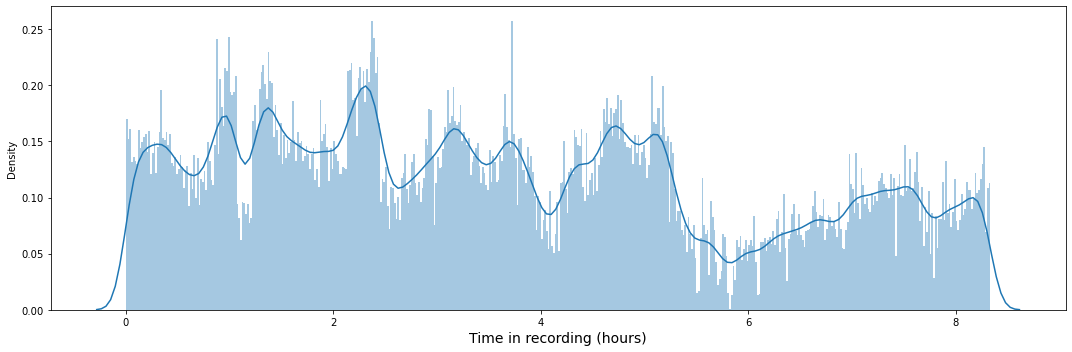

In [5]:
matplotlib.rcParams['figure.figsize'] = (15, 5)

sequence_starts = [spike[0] / (2048 * 60**2) for spike in all_seq_spikes]
ax = sns.distplot(sequence_starts, bins=end_min - start_min, kde_kws={"bw": 0.04})
ax.set_xlabel('Time in recording (hours)', fontsize=14)
plt.tight_layout()
plt.savefig(image_dir + '/ieds_over_time.pdf')

Plot histogram of inter-IED intervals, but this time using sequences rather than per-channel

Exclude first 12 hours, take following 24 hours, allow a gap for how long model training takes, then predict over remaining data.

In [6]:
X = features.copy()

y = []

sequence_starts = np.array([all_seq_spike[0] for all_seq_spike in all_seq_spikes])
for second in range(len(X)):
    y.append(len(sequence_starts[np.logical_and(sequence_starts > second * 2048, sequence_starts < (second + 1) * 2048)]))
#     y.append(len(spike_ids[np.logical_and(spike_ids > second * 2048, spike_ids < (second + 1) * 2048)]))
    
y = np.array(y)

imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
X = imp.fit_transform(X)

X = X[:-1]
y = y[1:]

np.save(ml_dir + '/X.npy', X)
np.save(ml_dir + '/y.npy', y)

In [9]:
N = 2000
cumsum, moving_aves = [0], []

for i, x in enumerate(y_clusters[0], 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
    else:
        moving_ave = cumsum[i] / i
    moving_aves.append(moving_ave)

plt.plot(np.array(moving_aves) / np.array(moving_aves).max(), label='No cluster')

cumsum, moving_aves = [0], []

for i, x in enumerate(y_clusters[1], 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
    else:
        moving_ave = cumsum[i] / i
    moving_aves.append(moving_ave)
    
plt.plot(np.array(moving_aves) / np.array(moving_aves).max(), label='Cluster 1')

cumsum, moving_aves = [0], []

for i, x in enumerate(y_clusters[2], 1):
    cumsum.append(cumsum[i-1] + x)
    if i>=N:
        moving_ave = (cumsum[i] - cumsum[i-N])/N
    else:
        moving_ave = cumsum[i] / i
    moving_aves.append(moving_ave)
    
plt.plot(np.array(moving_aves) / np.array(moving_aves).max(), label='Cluster 2')
plt.legend()

NameError: name 'y_clusters' is not defined

In [27]:
X = np.load('ml_data/DaKa/X.npy')
y = np.load('ml_data/DaKa/y.npy')
thresh = 3
channels = 89
model_dir = 'models/DaKa'
train_indices = [3960, 6780, 9600]
test_indices = [14880, 17640, 20400]

# Last hour is test set. Ignore previous hour.
X_trainval, X_test = X[:-7200], X[-3600:]
y_trainval, y_test = y[:-7200], y[-3600:]

def add_detections(X, y, seconds_list=[60, 300]):
    
    X_features_list = [X]
    
    for seconds in seconds_list:
        y_detections = y[:seconds * (len(y) // seconds)].reshape(-1, seconds).sum(axis=-1)
        X_features_list.append(np.append(np.array([0] * seconds), np.repeat(y_detections, seconds))[:len(y)][:, np.newaxis])        

    return np.concatenate(X_features_list, axis=1)

def get_features(X, channels, feature_space='full'):
    '''Get a subset of features'''
    
    features = {
        'baseline': X[:, -2:],
        'SEEG': X[:, :-2],
        'no coupling': np.concatenate([X[:, :-2-channels], X[:, -2:]], axis=1),
        'coupled': X[:, -2-channels:-2],
        'full': X,
    }
    
    return features[feature_space]

X_test_detected = add_detections(X_test, y_test, seconds_list=[60, 300])

X_test_ = get_features(X_test_detected, channels, 'baseline')

X_test_[:, -2:]

array([[  0.,   0.],
       [  0.,   0.],
       [  0.,   0.],
       ...,
       [114., 576.],
       [114., 576.],
       [114., 576.]])

In [30]:
y_test[:300].sum()

574

In [38]:
y_test.mean()

1.7277777777777779

In [39]:
y_trainval.mean()

2.2568095091889995

In [7]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pywt
import datetime as dt
from pandas.plotting import register_matplotlib_converters

In [8]:
window_length = 60

X_mins = features.copy()

y_mins = []

for second in range(int(len(X_mins) / window_length)):
    y_mins.append(len(spike_ids[np.logical_and(spike_ids > second * 2048 * window_length, \
                                          spike_ids < (second + 1) * 2048 * window_length)]))
    
y_mins = np.array(y_mins)

In [9]:
# fs = 1
frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / 1
print(1/frequencies)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.]


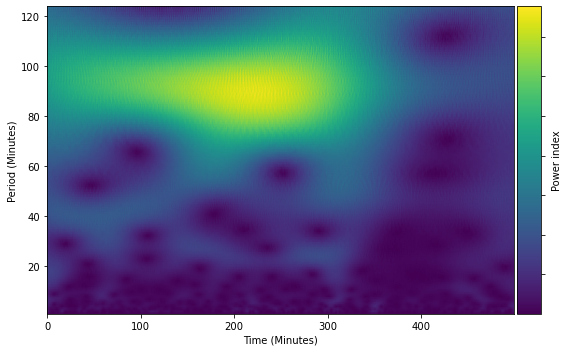

In [40]:
matplotlib.rcParams['figure.figsize'] = (8, 5)

to_use = y_mins

[coefficients_IEA, frequencies] = pywt.cwt(to_use, scales,'cmor1.5-1.0',1)
# power_IEA = np.log((abs(coefficients_IEA)))
power_IEA = abs(coefficients_IEA)
Periods = 1/frequencies

fig = plt.figure()
ax = fig.add_subplot(111)

# plt.figure(figsize=(8, 4))
c=ax.pcolormesh(range(len(to_use)),Periods,power_IEA,cmap='viridis', shading='gouraud',vmin = .6*power_IEA.min(), vmax = power_IEA.max())
# plt.title('Wavelet transform power')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(c, cax=cax)

# cbar = plt.colorbar(c)
cbar.set_label('Power index')
cbar.ax.set_yticklabels([])
ax.set_ylabel('Period (Minutes)')
ax.set_xlabel('Time (Minutes)')
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.tight_layout()
plt.savefig(image_dir + '/spectogram.pdf')
plt.show()

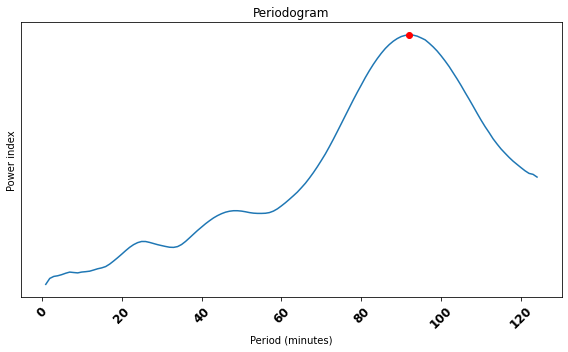

In [11]:
matplotlib.rcParams['figure.figsize'] = (8, 5)

# Periodogram
power_IEA = (abs(coefficients_IEA))
Av_power = np.mean(power_IEA, axis=1)

plt.figure()
plt.title('Periodogram')
plt.plot(Periods, Av_power)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.xlabel('Period (minutes)')
plt.ylabel('Power index')
plt.yticks([])

sm_Av_power = signal.savgol_filter(Av_power, 11, 1)  
# we smooth the periodogram to find its peak with a window size of 11 and a  polynomial fit of order 7
peaks, properties = signal.find_peaks(sm_Av_power,np.mean(sm_Av_power)) #We find the few peaks of the periodogram
hights = properties['peak_heights']

plt.plot(Periods[peaks[0]], Av_power[peaks[0]],'ro')

plt.tight_layout()
plt.savefig(image_dir + '/periodogram.pdf')
plt.show() 

In [935]:
peaks[0]

91

In [860]:
# # peak frequency 
# sm_Av_power = signal.savgol_filter(Av_power, 11, 1)  
# # we smooth the periodogram to find its peak with a window size of 11 and a  polynomial fit of order 7
# peaks, properties = signal.find_peaks(sm_Av_power,np.mean(sm_Av_power)) #We find the few peaks of the periodogram
# hights = properties['peak_heights']
# plt.figure()
# plt.title('Periodogram')
# plt.plot(Periods, Av_power)
# plt.xticks(weight='bold', fontsize=12, rotation=45)
# plt.xlabel('Period (minutes)')
# plt.ylabel('Power index')
# plt.yticks([])
# #plt.plot(Periods[peaks[0:3]],Av_power[peaks[0:3]],'yo')
# # plt.plot(Periods[peaks], Av_power[peaks],'yo')

# plt.plot(Periods[peaks[0]], Av_power[peaks[0]],'ro')
# plt.tight_layout()
# plt.show()
# print('Peak of the periodogram = %0.0f' %Peak_period)

Extracting phase between 62 and 122 days


/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jamienorris/miniconda3/envs/lightgbm/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.04 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


[3960]
[9600]
[14880]
[20400]
[25620]


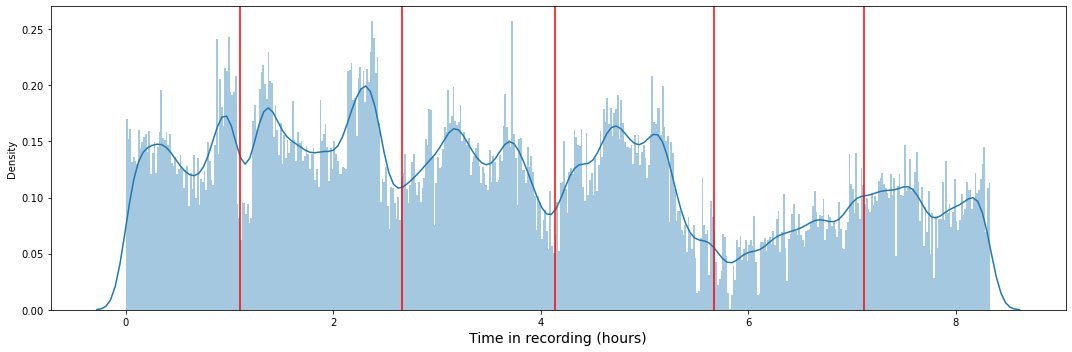

In [12]:
Peak_period = (Periods[peaks[np.argmax(hights)]])  # We take the peak-periodicity with the highest power

# take the peak of the periodogram
max_Pk = peaks[np.argmax(hights)]
max_Pk_inf = (round(Peak_period-.33*Peak_period))
max_Pk_sup = (round(Peak_period+.33*Peak_period))

idx_min = (np.abs(Periods - max_Pk_inf)).argmin()
idx_max = (np.abs(Periods - max_Pk_sup)).argmin()

print('Extracting phase between %0.0f and %0.0f days' %(max_Pk_inf,max_Pk_sup))

angle_peak_IEA=np.angle(coefficients_IEA[idx_min:idx_max,:].mean(axis=0))


diffs = np.diff(angle_peak_IEA)

matplotlib.rcParams['figure.figsize'] = (15, 5)

sequence_starts = [spike[0] / (2048 * 60**2) for spike in all_seq_spikes]
ax = sns.distplot(sequence_starts, bins=end_min - start_min, kde_kws={"bw": 0.04})
ax.set_xlabel('Time in recording (hours)', fontsize=14)

for cycle_start in np.argwhere(diffs < -2):
# for cycle_start in [222, 563, 845, 1157]:
    print(cycle_start * 60)
    plt.axvline(cycle_start/ 60, color='r')
    
plt.tight_layout()
plt.savefig(image_dir + '/ied_cycles.pdf')

In [513]:
# 158:249, 249:344
# 221:563:844

#844:1156
np.diff(angle_peak_IEA).argsort()[:10]

array([ 219, 1156,  221,  844, 1158,  840,  563,  760,  731,  729])